In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from hol.count_wpm import CountWPM
from hol.anchored_count_wpm import AnchoredCountWPM

year1 = 1750
year2 = 1920

wpm0 = CountWPM(year1, year2)
wpm1 = AnchoredCountWPM(year1, year2)

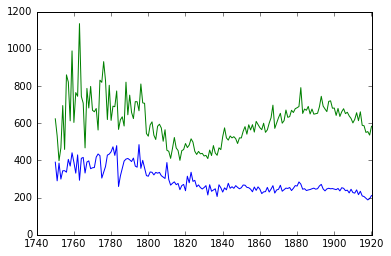

In [5]:
series = wpm0.series('art')
plt.plot(*zip(*series.items()))

series = wpm1.series('art')
plt.plot(*zip(*series.items()))

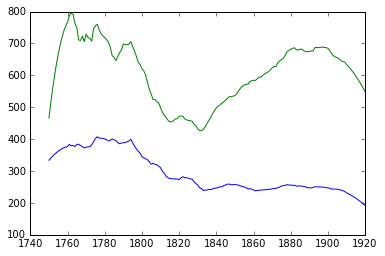

In [6]:
series = wpm0.series_smooth('art')
plt.plot(*zip(*series.items()))

series = wpm1.series_smooth('art')
plt.plot(*zip(*series.items()))